This is part 1 of my analysis of Benjamin Pavard's goal against Argentina in the quarter finals of the 2018 FIFA World Cup. 

In [1]:
import polars as pl 
from statsbombpy import sb 
from kloppy import metrica
from dataclasses import dataclass

import mplsoccer as mpl
import numpy as np


import sys
sys.path.append("..") 

import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils.statics import figsize, PITCH_X, PITCH_Y
from utils.utils import invert_orientation, add_legend, extract_team_from_tactics

# Prepare the data
Call the matches method from the ``sb`` module. The method calls the Statsbomb API and returns a Pandas dataframe of all matches for the provided ``competition_id`` and ``season_id``. I have decided to do perform this analysis using the ``polars`` library, since its syntax is more similar to PySpark.

You can read more about polars here: https://pola.rs/

In [3]:
wc2018_matches_df = sb.matches(competition_id=43, season_id=3).sort_values('match_date', ascending=False)
wc2018_matches = pl.from_pandas(wc2018_matches_df)

In [4]:
wc2018_matches.select(pl.col("competition_stage").unique())

competition_stage
str
"""3rd Place Final"""
"""Final"""
"""Semi-finals"""
"""Quarter-finals"""
"""Group Stage"""
"""Round of 16"""


Now let us find the Round of 16 match between France and Argentina

In [5]:
ro16_match = wc2018_matches.filter((pl.col("competition_stage") == "Round of 16") & ((pl.col("home_team") == 'France') | (pl.col("away_team") == 'France')))

Now for this particular match, we have to call the events method to get event data for this match.

In [6]:
match_id = 7580
events_df = sb.events(match_id = match_id)
events = pl.from_pandas(events_df)


# Match statistics
I am specifically interested in analysing the Benjamin Pavard's goal that made the score 2-2, but let us first explore some interesting statistics for 
this game.

## Heat map
We first filter the Polars dataframe to obtain the events with a location for France and Argentina respectively. 

In [7]:
france_events = events.filter((pl.col("location").is_not_null()) & (pl.col("team") == 'France') )
arg_events = events.filter(pl.col("location").is_not_null() & (pl.col("team") == "Argentina"))

We extract the (x,y) coordinates for all France's and Argentina's actions.

In [8]:
france_x, france_y = np.array(france_events.select(pl.col("location")).to_series().to_list()).transpose()
argentina_x, argentina_y = np.array(arg_events.select(pl.col("location")).to_series().to_list()).transpose()

# reverse the orientation of Argentina's actions
arg_x, arg_y = invert_orientation(argentina_x, argentina_y, PITCH_X)

To get an idea of where their actions are taken on the pitch, we construct a Kernel Density Estimation plot on top of the pitch.

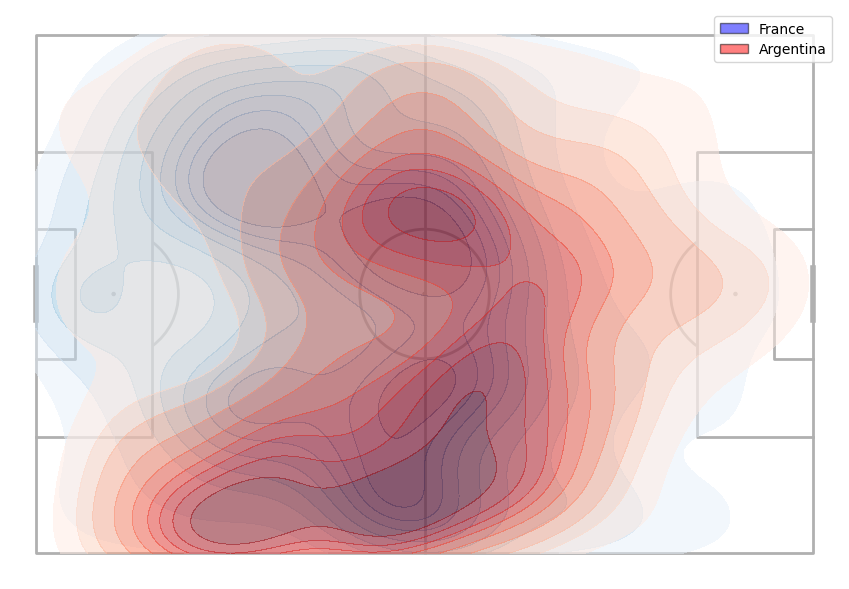

In [9]:
pitch = mpl.Pitch(pitch_type='statsbomb', pitch_length=PITCH_X, pitch_width=PITCH_Y)
fig, ax = pitch.draw(figsize=figsize)
k1 = pitch.kdeplot(france_x, france_y, cmap='Blues', fill=True, levels=10, alpha=0.5, ax=ax)
k2 = pitch.kdeplot(arg_x, arg_y, cmap='Reds', fill=True, levels=10, alpha=0.5, ax=ax)

add_legend(ax=ax, num_elements=2, colors=["blue", "red"], labels=["France", "Argentina"])


France seems to have dominated the midfield, and with a double pivot of N'Golo Kante and Paul Pogba, with the addition of Blaise Matuidi on the left, this reflects the density peaks in those positions.

Argentina on the other hand seems to have taken most of their actions on the left side. Looking at their startup, this is most likely attributed to Ángel Di María. Inspired by [this post](https://karun.in/blog/interactive-passing-networks.html) by Karun Singh, let us plot the average positions of the players of the starting 11.

In [16]:
tactics = events.filter(pl.col("type") == "Starting XI").select(pl.col("tactics"))

starting_xi = extract_team_from_tactics(tactics)
france_starting = starting_xi.filter(pl.col("team") == "France").select(pl.col("player_id")).to_series().to_list()
argentina_starting = starting_xi.filter(pl.col("team") == "Argentina").select(pl.col("player_id")).to_series().to_list()

In [18]:
# Filter events for starting 11 only
france_11_events = france_events.filter(pl.col("player_id").is_in(france_starting))
argentina_11_events = arg_events.filter(pl.col("player_id").is_in(argentina_starting))


In [ ]:
(france_events
 .select(pl.col("location").list.get(0).alias("x"), pl.col("location").list.get(1).alias("y"), pl.col("player_id"))
 .group_by("player_id")
 .agg(pl.mean("x").alias("avg_x"), pl.mean("y").alias("avg_y")))

player_id,avg_x,avg_y
f64,f64,f64
5480.0,47.534884,21.813953
5485.0,38.767857,56.830357
4375.0,56.984848,21.560606
2948.0,56.461538,49.038462
3604.0,70.508929,36.089286
…,…,…
3961.0,47.661836,31.285024
3254.0,39.666667,74.333333
5487.0,69.139344,45.295082


In [25]:
france_avg_pos = (
    france_11_events
    .with_columns([
        pl.col("location").arr.get(0).alias("x"),  # extract first element of the tuple
        pl.col("location").arr.get(1).alias("y")   # extract second element
    ])
    .group_by("player_id")
    .agg([
        pl.mean("x").alias("avg_x"),
        pl.mean("y").alias("avg_y")
    ])
)

SchemaError: invalid series dtype: expected `Array`, got `list[f64]` for series with name `location`

In [36]:
# Convert 'location' list[f64] into a struct with fields 0 and 1
df_with_coords = france_11_events.with_columns([
    pl.col("location").arr.to_struct(n_fields=2).alias("loc_struct")
])

# Extract x and y from the struct fields
df_with_coords = df_with_coords.with_columns([
    pl.col("loc_struct").struct.field("field_0").alias("x"),
    pl.col("loc_struct").struct.field("field_1").alias("y")
])

# Compute average positions per player
france_avg_pos = (
    df_with_coords
    .group_by("player_id")
    .agg([
        pl.mean("x").alias("avg_x"),
        pl.mean("y").alias("avg_y")
    ])
)


TypeError: ExprArrayNameSpace.to_struct() got an unexpected keyword argument 'n_fields'

In [34]:
france_avg_pos

player_id,avg_x,avg_y
f64,f64,f64
3961.0,47.661836,31.285024
5492.0,37.467742,24.693548
5476.0,48.542373,67.516949
3009.0,69.523179,58.264901
4375.0,56.984848,21.560606
…,…,…
5484.0,48.728972,9.803738
5487.0,69.139344,45.295082
3604.0,70.508929,36.089286


In [11]:
# # Get starting 11 player ids for each team
# lineups = sb.lineups(match_id=match_id)
# france_starting = [p['player_id'] for p in lineups['France']]
# argentina_starting = [p['player_id'] for p in lineups['Argentina']]

# # Get player names for legend
# france_names = {p['player_id']: p['player_name'] for p in lineups['France']['starting_lineup']}
# argentina_names = {p['player_id']: p['player_name'] for p in lineups['Argentina']['starting_lineup']}

# # Filter events for starting 11 only
# france_11_events = france_events.filter(pl.col("player_id").is_in(france_starting))
# argentina_11_events = arg_events.filter(pl.col("player_id").is_in(argentina_starting))

# # Compute average positions
# france_avg = (
#     france_11_events
#     .groupby("player_id")
#     .agg([
#         pl.col("location").apply(lambda locs: np.mean(np.stack(locs), axis=0)).alias("avg_loc")
#     ])
#     .to_pandas()
# )
# argentina_avg = (
#     argentina_11_events
#     .groupby("player_id")
#     .agg([
#         pl.col("location").apply(lambda locs: np.mean(np.stack(locs), axis=0)).alias("avg_loc")
#     ])
#     .to_pandas()
# )

# # Reverse Argentina orientation
# argentina_avg['avg_loc'] = argentina_avg['avg_loc'].apply(lambda loc: invert_orientation(loc[0], loc[1], PITCH_X, PITCH_Y))

# # Plot
# fig, ax = pitch.draw(figsize=figsize)
# # France
# for _, row in france_avg.iterrows():
#     x, y = row['avg_loc']
#     ax.scatter(x, y, color='blue', s=100)
#     ax.text(x, y, france_names[row['player_id']].split()[-1], color='blue', fontsize=8, ha='center', va='center')
# # Argentina
# for _, row in argentina_avg.iterrows():
#     x, y = row['avg_loc']
#     ax.scatter(x, y, color='red', s=100)
#     ax.text(x, y, argentina_names[row['player_id']].split()[-1], color='red', fontsize=8, ha='center', va='center')
# add_legend(ax=ax, num_elements=2, colors=["blue", "red"], labels=["France", "Argentina"])
# ax.set_title("Average positions of starting 11 (France & Argentina)")